In [660]:
import h5py
import sys
import numpy as np
import scipy.signal as scisig
from scipy import io
from scipy.signal import hilbert as hilbert
from math import *;

import re
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

import verasonics_data as vus

import pandas as pd

In [4]:
%matplotlib inline

In [114]:
path="/media/caskeylab/DATAPART1/Data/Verasonics/2017-03-21 250kHz PCD/"
BubblesPARA = glob.glob(path+"Bubbles[0-9]*.bin")
BubblesPERP = glob.glob(path+"BubblesPerp*.bin")
NonePARA = glob.glob(path+"NoBubbles[0-9]*.bin")
NonePERP = glob.glob(path+"NoBubblesPerp*.bin")

#### Parse filenames for voltage, bubbles, perpendicular ####

In [375]:
rows=[]

for file in BubblesPARA:
    filebase = os.path.basename(file)
    #print(filebase)
    res=re.search('(\d+)mV(\d+)', filebase)
    (mV,trial) = [int(x) for x in res.groups()]

    rows.append( dict(mv=mV, trial=trial, file=filebase, bubbles=True, perp=False))
    
for file in BubblesPERP:
    filebase = os.path.basename(file)
    #print(filebase)
    res=re.search('(\d+)mV(\d+)', filebase)
    (mV,trial) = [int(x) for x in res.groups()]

    rows.append( dict(mv=mV, trial=trial, file=filebase, bubbles=True, perp=True))
    
for file in NonePARA:
    filebase = os.path.basename(file)
    #print(filebase)
    res=re.search('(\d+)mV', filebase)
    rows.append( dict(mv=int(res.group(1)), trial=1, file=filebase, bubbles=False, perp=False))
    
for file in NonePERP:
    filebase = os.path.basename(file)
    #print(filebase)
    res=re.search('(\d+)mV', filebase)
    rows.append( dict(mv=int(res.group(1)), trial=1, file=filebase, bubbles=False, perp=True))
    
# convert to Pandas DataFrame for convenience
df = pd.DataFrame(rows)


#### Load one file to establish for reconstruction grid and delays ####
`'s0'` is the number of initial samples to remove from the channel data

In [368]:

(parfile, junk) = vus.getParamFile(BubblesPARA[0])

params = vus.load_cavitation_params(parfile)
params.num_final_bmode_acs = 0

(rf_data, junk) = vus.load_veradata_128_bin(BubblesPARA[0], params=params)

(ns,Nchan,nacq) = rf_data.shape

s0 = 900
rf_data = rf_data[s0:]
ns = rf_data.shape[0]

In [403]:
c0 = 1480 #m/s
dx = 3e-4 #meters
dz = 3e-4 #meters
dt = 1.0 / params.fs

ducer_width = params.pitch*Nchan

Nx = round(ducer_width/dx)

xpnts = np.linspace(-0.5,0.5,Nx)*Nx*dx
zpnts = np.arange(3e-2,7e-2,dz)
Nz=len(zpnts)

ux = (np.linspace(-0.5,0.5,Nchan)*Nchan + 0.5)*params.pitch
uz = 0.0

imgextent = np.array([xpnts[0],xpnts[-1],zpnts[-1],zpnts[0]])*100

In [404]:
(distances,delayinds, inbounds, ii,ape) = vus.getProbe2DelaySet(uz, ux, zpnts, xpnts, c0, dt, ns)

delayed_data = np.zeros_like(distances)

#### Use the first 50 acquisitions and allocated storage ####

In [406]:
acqlist = range(0,50)

mom1=np.zeros([len(acqlist), Nz,Nx])
mom2=np.zeros([len(acqlist), Nz,Nx])
variance = np.zeros([len(acqlist)])

### Loop over files, reconstruct PAM images and extract variance ###

In [741]:

nfiles=len(df)
inputs = range(nfiles)
#inputs=[0]
rows=[]

for fi in inputs:
    
    (rf_data, junk) = vus.load_veradata_128_bin(path + df.iloc[fi].file, params=params)

    rf_data = rf_data[s0:]
    (ns,Nchan,nacq) = rf_data.shape

    print(df.iloc[fi].file)
    
    row=df.iloc[fi]
    
    delayed_data*=0
    for acq in acqlist:
    
        delayed_data[ii[0],ii[1],ii[2]] = rf_data[delayinds[inbounds],ii[2],acq]

        chandelaysum = np.sum(ape*distances*delayed_data,axis=2)
        chandelaysum2 = np.sum( (ape*distances*delayed_data)**2,axis=2) 
        mom1[acq] = chandelaysum
        mom2[acq] = chandelaysum2

        variance[acq] = np.var(delayed_data[ii[0],ii[1],ii[2]])
        
    m1rms = np.mean( mom1**2, axis=0)
    m1avg = np.mean( mom1, axis=0)
    m2 = np.mean( mom2, axis=0)
    
    pamvar = np.mean( m1rms - (m1avg**2) )
    
    rows.append(dict(file=row.file, mv=row.mv, trial=row.trial, perp=row.perp, bubbles=row.bubbles, 
                     m1rms=m1rms, m1avg=m1avg, m2=m2,
                     m1mag=np.mean(m1rms),m2mag=np.mean(m2), pamvar=pamvar,
                     var=variance.copy(), totvar=np.mean(variance)))
    
analysisFrame = pd.DataFrame(rows)

Bubbles120mV1.bin
Bubbles120mV2.bin
Bubbles120mV3.bin
Bubbles120mV4.bin
Bubbles120mV5.bin
Bubbles39mV1.bin
Bubbles39mV2.bin
Bubbles39mV4.bin
Bubbles39mV5.bin
Bubbles79mV1.bin
Bubbles79mV2.bin
Bubbles79mV3.bin
Bubbles79mV4.bin
Bubbles79mV5.bin
Bubbles39mV3.bin
BubblesPerp120mV2.bin
BubblesPerp120mV3.bin
BubblesPerp120mV4.bin
BubblesPerp120mV5.bin
BubblesPerp39mV1.bin
BubblesPerp39mV2.bin
BubblesPerp39mV3.bin
BubblesPerp39mV5.bin
BubblesPerp79mV1.bin
BubblesPerp79mV2.bin
BubblesPerp79mV3.bin
BubblesPerp79mV4.bin
BubblesPerp79mV5.bin
BubblesPerp120mV1.bin
BubblesPerp39mV4.bin
NoBubbles120mV.bin
NoBubbles39mV.bin
NoBubbles79mV.bin
NoBubblesPerp120mV.bin
NoBubblesPerp39mV.bin
NoBubblesPerp79mV.bin


-----

### Total cavitation in first 50 frames ###

##### pamvar #####
Average value of the first 50 PAM images
##### totvar #####
Average raw channel variance of first 50 acquisitions.

* `_avg` averaged over the 5 trials. 

* `_std` std deviation over the 5 trials. (No replicates were done for 'NoBubbles', hence std =0).

In [718]:
grpby = analysisFrame.groupby(("perp","bubbles","mv"))

aggs = {
    'totvar': dict(totvar_avg='mean', totvar_std='std'),
    'pamvar': dict(pam_avg='mean', pam_std='std')
}


ag=grpby.agg(aggs).fillna('0')
ag

pamvar                  totvar           
                       pam_avg    pam_std   totvar_avg totvar_std
perp  bubbles mv                                                 
False False   39      1.042840          0     2.808452          0
              79      1.046268          0     2.822515          0
              120     1.046489          0     2.836085          0
      True    39      5.441750    3.30736     6.697355    2.95865
              79    231.575051    45.2281   252.861062    45.9534
              120  1311.220474    211.514  1614.494537    272.017
True  False   39      1.046868          0     2.817285          0
              79      1.050719          0     2.840992          0
              120     1.048615          0     2.863277          0
      True    39      1.056943  0.0181708     2.830686  0.0243329
              79      2.058081    1.51694     4.045454    1.83359
              120     9.961523    10.4409    14.208808     13.139

In [719]:
ag.to_csv('/home/caskeylab/DataDrive/Verasonics/2017-03-21 250kHz PCD/Jiro_PAMandVariance.csv')

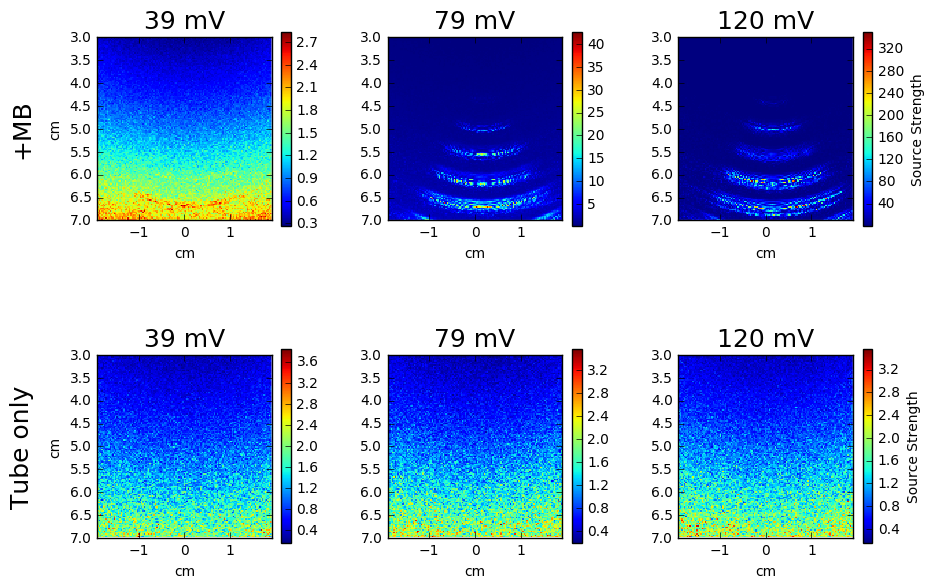

In [716]:
sets = analysisFrame.query("perp").groupby(("bubbles", "mv"))
bub=[True, False]
mvs=[39,79,120]

gs=gridspec.GridSpec( 2, 3, wspace=0.5,hspace=0.05)
fig=plt.figure(figsize=(10,8))

for bi in range(2):
    if bub[bi]:
        bstr="+MB"
    else:
        bstr="Tube only"
        
    for mvi in range(len(mvs)):
        ax = fig.add_subplot(gs[bi,mvi] )

        mV = mvs[mvi]
        mvtrial = sets.get_group((bub[bi], mV))
        avgImageFromGroup = np.mean( mvtrial.m1rms - mvtrial.m1avg**2  )

        im=ax.imshow( avgImageFromGroup,extent=imgextent, interpolation='none')
        

        ax.text(0.5,1.05,"%d mV"%mV, transform=ax.transAxes, horizontalalignment='center', fontsize=18)
        ax.set_xticks([-1,0,1])
        
        
        ax.set_xlabel('cm')
        if mvi==0:
            ax.set_ylabel('cm')
            ax.text(-0.5,0.5,bstr, transform=ax.transAxes, verticalalignment='center', rotation=90, fontsize=18)
        if mvi==2:
            cb=plt.colorbar(mappable=im, label="Source Strength",fraction=0.05)
        else:
            cb=plt.colorbar(mappable=im,fraction=0.05)

In [717]:
fig.savefig("/home/caskeylab/DataDrive/Verasonics/2017-03-21 250kHz PCD/Bubbles_images_perp.png")

### PSF Deconvolve ###

In [646]:
file="/home/caskeylab/DataDrive/Verasonics/simulation_Harm250_x450_y300.mat"

matdict=io.loadmat(file,squeeze_me=True,struct_as_record=False)

#load data
pr_data=matdict['sensor_data'].p
p_final=matdict['sensor_data'].p_final

#Nschan=pr_data.shape[0]
Nst=pr_data.shape[1]
times = np.arange(0, Nst*matdict['dt'],matdict['dt'])
simDims = (matdict['Nx'], matdict['Ny'] )

psfz=np.arange(0.0,6.0e-2,dz)
psfx=np.arange(-1.5e-2,1.5e-2,dx)

z0i = round(450*matdict['d'] / dz)
x0j = round(len(psfx) / 2)

In [636]:
(sim_distances,sim_delayinds, sim_inbounds, sim_ii, junk) = vus.getProbe2DelaySet(uz, ux, psfz,psfx, c0, matdict['dt'], Nst)
sim_delayed_data = np.zeros_like(sim_distances)

In [720]:
sim_delayed_data[sim_ii[0],sim_ii[1],sim_ii[2]] = pr_data[sim_ii[2], sim_delayinds[sim_inbounds]]
chandelaysum = np.sum((sim_distances*sim_delayed_data)**2,axis=2)

psfimg = chandelaysum**2

PSFarray = psfimg.copy()
def PSFij(z,x):
    row = np.floor( z/dz + z0i ).astype(int)
    col = np.floor( x/dx + x0j ).astype(int)
    
    return (row,col)

def PSF(z,x):
    (row,col) = PSFij(z,x)
 
    return PSFarray[row,col]

In [721]:
rgz,rgx=np.meshgrid(np.arange(-0.02,0.02,dz), np.arange(-0.01,0.01,dx), indexing='ij')
psf_h = PSF(rgz,rgx)
psf_hconj = PSF(-rgz,-rgx)


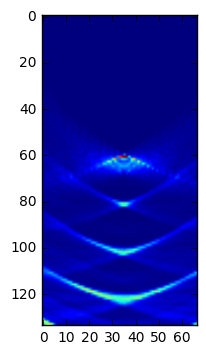

In [722]:
plt.imshow(psf_h)

In [707]:
pcmap = np.mean( analysisFrame.query("perp and bubbles and mv==79").m1rms )

In [723]:
fn = pcmap.copy()

fnset=[pcmap]
for i in range(0,10):
    print(i)
    res = scisig.convolve2d(fn, psf_h,mode='same')
    fn1 = fn*scisig.convolve2d(fn/res, psf_hconj, mode='same')
    fnset.append(fn1)
    fn=fn1

0
1
2
3
4
5
6
7
8
9


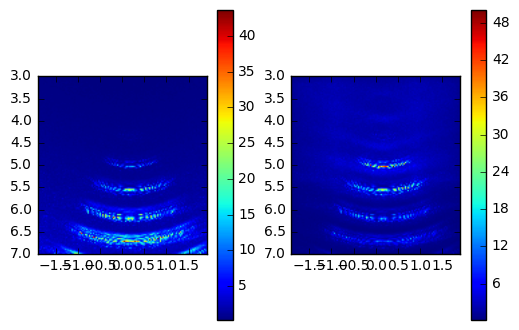

In [731]:
plt.subplot(121)
plt.imshow((fnset[0]) ,extent=imgextent)
plt.colorbar()
plt.subplot(122)
plt.imshow((fnset[2]),extent=imgextent)
plt.colorbar()

In [736]:
analysisFrame[['file','bubbles','perp','mv','var','totvar']]

,file,bubbles,perp,mv,var,totvar
0,Bubbles120mV1.bin,True,False,120,"[2.81118798389, 2.87949141572, 2.86371000552, ...",2065.683699
1,Bubbles120mV2.bin,True,False,120,"[2.81118798389, 2.87949141572, 2.86371000552, ...",1461.477767
2,Bubbles120mV3.bin,True,False,120,"[2.81118798389, 2.87949141572, 2.86371000552, ...",1510.811162
3,Bubbles120mV4.bin,True,False,120,"[2.81118798389, 2.87949141572, 2.86371000552, ...",1657.472996
4,Bubbles120mV5.bin,True,False,120,"[2.81118798389, 2.87949141572, 2.86371000552, ...",1377.027063
5,Bubbles39mV1.bin,True,False,39,"[2.81118798389, 2.87949141572, 2.86371000552, ...",6.968762
6,Bubbles39mV2.bin,True,False,39,"[2.81118798389, 2.87949141572, 2.86371000552, ...",3.556702
7,Bubbles39mV4.bin,True,False,39,"[2.81118798389, 2.87949141572, 2.86371000552, ...",5.017497
8,Bubbles39mV5.bin,True,False,39,"[2.81118798389, 2.87949141572, 2.86371000552, ...",11.411993
9,Bubbles79mV1.bin,True,False,79,"[2.81118798389, 2.87949141572, 2.86371000552, ...",213.521738
